### IE801 물류관리 HW1

- 이름 : 이강훈
- 학번 : 20203421

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import copy

### Generating Graph

생성되는 그래프는 다음의 조건들을 만족한다.

- source node는 1번 노드이다.
- 각 노드의 incoming edge는 자기 자신보다 낮은 index의 노드로만 형성된다.
- 각 노드의 outgoing edge는 자기 자신보다 높은 index의 노드로만 형성된다.
- source node를 제외한 모든 노드는 최소 1개의 incoming edge를 가진다.
- 각 노드의 incoming edge, outgoing edge의 합은 최소 'degree' 이다.

위의 조건을 통해 다음의 특징을 가진다.

- source node에서 모든 노드까지의 path가 존재한다.
- 그래프에는 cycle이 존재하지 않는다.

랜덤성을 위해서 위의 조건으로 만들어진 그래프를 source node를 제외하고 node들을 relable 한다.

In [2]:
def cost_function(negative_prob=0.0):
    
    if random.random() < negative_prob:
        return -random.random()
    else:
        return random.random()

In [3]:
def remapper(num_nodes):
    remap = {1:1}
    target_node = list(range(2, num_nodes+1))
    random.shuffle(target_node)
    for i in range(2, num_nodes+1):
        remap[i] = target_node[i-2]
    return remap

In [4]:
def generate_network(num_nodes, degree, min_edge, cost_function, negative_prob):
    
    while True:
        G = nx.DiGraph()
        G.add_node(num_nodes)

        for i in range(1, num_nodes+1):
            pool = list(range(1, num_nodes+1))
            pool.remove(i)
            picked_nodes = random.sample(pool, degree)

            in_num = 0
            for picked_node in picked_nodes:
                if i < picked_node:
                    G.add_edge(i, picked_node, cost=cost_function())
                else:
                    G.add_edge(picked_node, i, cost=cost_function())
                    in_num += 1

            if i > 1 and in_num <= 0:
                picked_node = random.sample(list(range(1, i)), 1)[0]
                G.add_edge(picked_node, i, cost=cost_function())
        
        if G.number_of_edges() > min_edge:
            
            pool = list(range(G.number_of_edges()))
            num_negative = round(G.number_of_edges() * negative_prob)
            negative_edges = random.sample(pool, num_negative)
            
            for i in negative_edges:
                u, v = list(G.edges())[i]
                G[u][v]['cost'] = -G[u][v]['cost']
                
            mapping = remapper(num_nodes)
            G = nx.relabel_nodes(G, mapping)
            
            return G

### Test 'generate_network' function

- 네트워크가 어떻게 생성되었는지 visualize
- source node(1번 노드)는 다른색으로 구분

In [5]:
def make_colormap(num_nodes, source_color='coral', basic_color='lightgreen'):
    color = []
    for i in pos.keys():
        if i == 1:
            color.append(source_color)
        else:
            color.append(basic_color)
    return color

number of nodes :  20
number of edges :  46


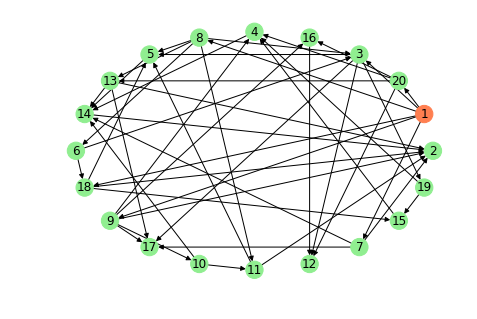

In [6]:
num_nodes = 20
degree = 2
min_edge = 40

G = generate_network(num_nodes=num_nodes, 
                     degree=degree, 
                     min_edge=min_edge, 
                     cost_function=cost_function, 
                     negative_prob=0.1)

print("number of nodes : ", G.number_of_nodes())
print("number of edges : ", G.number_of_edges())

pos = nx.circular_layout(G)
color = make_colormap(num_nodes)
nx.draw(G, pos, node_color = color, with_labels = True)


### Bellman-Ford Algorithm

- source node 에서 각 node 별로 최단 경로, 최소 비용을 구하는 알고리즘
- $d[i]$ : cost to $i$
- $prev[i]$ : previous node for path-$i$

In [7]:
def bellman_ford(G):
    
    # define variable
    d = ['dummy'] + [0] + [1e+6] * (G.number_of_nodes() - 1)
    prev = ['dummy'] + [-1] * G.number_of_nodes()
    
    cnt = 0
    for _ in range(1, len(d)):        
        for i, j in G.edges():
            cnt += 1
            if d[j] > d[i] + G[i][j]['cost']:
                d[j] = d[i] + G[i][j]['cost']
                prev[j] = i
    
    return d[1:], prev[1:], cnt

### Test Bellman-Ford Algorithm

- bellman-ford 알고리즘 테스트

In [8]:
def path_beautiful(d, prev):
    
    path = ['1'] + [''] * (len(d) - 1)
    
    for i in range(20):
        cur_id = i
        path_i = str(i+1)
        while prev[cur_id] != -1:
            path_i = str(prev[cur_id]) + ' -> ' + path_i
            cur_id = prev[cur_id] - 1
        
        print("node {:2d} / cost : {:1.4f} / path : {}"
              .format(i+1, d[i], path_i))
        
    return path

In [9]:
d, prev, _ = bellman_ford(G)
path = path_beautiful(d, prev)

node  1 / cost : 0.0000 / path : 1
node  2 / cost : -0.1189 / path : 1 -> 8 -> 13 -> 2
node  3 / cost : 0.3354 / path : 1 -> 3
node  4 / cost : 0.9093 / path : 1 -> 9 -> 4
node  5 / cost : 0.0157 / path : 1 -> 8 -> 5
node  6 / cost : 1.2095 / path : 1 -> 8 -> 6
node  7 / cost : 0.2606 / path : 1 -> 7
node  8 / cost : 0.4505 / path : 1 -> 8
node  9 / cost : 0.0893 / path : 1 -> 9
node 10 / cost : 0.9314 / path : 1 -> 9 -> 10
node 11 / cost : 0.8209 / path : 1 -> 8 -> 11
node 12 / cost : 0.8571 / path : 1 -> 3 -> 12
node 13 / cost : 0.5689 / path : 1 -> 8 -> 13
node 14 / cost : 0.1673 / path : 1 -> 8 -> 5 -> 14
node 15 / cost : 0.6510 / path : 1 -> 18 -> 15
node 16 / cost : 0.3169 / path : 1 -> 9 -> 16
node 17 / cost : 0.0888 / path : 1 -> 9 -> 17
node 18 / cost : 0.4924 / path : 1 -> 18
node 19 / cost : 1.2558 / path : 1 -> 3 -> 19
node 20 / cost : 0.9908 / path : 1 -> 20


### Modified Bellman-Ford Algorithm - add & remove

- check list 에서 어떤 item 을 remove 해야할까?
- check list 에서 item 을 어떤 위치에 add 해야할까?

여러가지 방식이 있을 수 있는데, 다음과 같은 방법을 생각할 수 있다.

1. FIFO
    - remove : 맨 앞에 있는 item
    - add : 맨 뒤에 add


2. Dequeue
    - remove : 맨 앞에 있는 item
    - add : 새로운 node의 경우 맨 뒤에, 다시 들어온 node의 경우 맨 앞에


3. Random
    - remove : random 한 위치에 있는 item
    - add : random 한 위치에 add

In [10]:
class FIFO_method:
    
    def __init__(self):
        pass
    
    def remove(self, check_list):
        return check_list.pop(0)
    
    def add(self, check_list, idx):
        check_list.append(idx)

In [11]:
class Dequeue_method:
    
    def __init__(self):
        self.visited = []
    
    def remove(self, check_list):
        return check_list.pop(0)
    
    def add(self, check_list, idx):
        if idx in self.visited:
            check_list.insert(0, idx)
        else:
            self.visited.append(idx)
            check_list.append(idx)

In [12]:
class Random_method:
    
    def __init__(self):
        pass
    
    def remove(self, check_list):
        return check_list.pop(random.randrange(len(check_list)))
    
    def add(self, check_list, idx):
        check_list.insert(random.randrange(len(check_list)+1), idx)

### Modified Bellman-Ford Algorithm

여러가지 add, remove method를 사용할 수 있는 bellman-ford 함수 정의.

In [13]:
def make_edge_dict(G):

    edge_dict = {}
    
    for u, v in G.edges():
        if not (u in edge_dict.keys()):
            edge_dict[u] = [v]
        else:
            edge_dict[u] += [v]

    return edge_dict

In [14]:
def modified_bellman_ford(G, method):
    
    # define variable
    d = ['dummy'] + [0] + [1e+6] * (G.number_of_nodes() - 1)
    prev = ['dummy'] + [-1] * G.number_of_nodes()
    check_list = [1]
    
    edge_dict = make_edge_dict(G)
    cnt = 0
    while len(check_list) != 0:
        i = method.remove(check_list)
        if not (i in edge_dict.keys()):
            continue
            
        for j in edge_dict[i]:
            cnt += 1
            if d[j] > d[i] + G[i][j]['cost']:
                d[j] = d[i] + G[i][j]['cost']
                prev[j] = i
                if not (j in check_list):
                    method.add(check_list, j)
    
    return d[1:], prev[1:], cnt

### Problem 1 : Compare the performances of the methods

- graph generation : 5000 graphs for test
- 10% of edges are negative costs

In [15]:
def make_test_sets(negative_prob):

    num_nodes = 20
    degree = 2
    min_edge = 40

    test_sets = 5000

    Graphs = []
    for _ in range(test_sets):
        G = generate_network(num_nodes=num_nodes, 
                             degree=degree, 
                             min_edge=min_edge, 
                             cost_function=cost_function, 
                             negative_prob=negative_prob)
        Graphs.append(G)
    return Graphs

In [16]:
def method_test(test_set, method):
    cnt = []
    for G in test_sets:
        _, _, cnt_ = modified_bellman_ford(G, method=copy.deepcopy(method))
        cnt.append(cnt_)

    cnt = np.array(cnt)
    mean_ = cnt.mean()
    std_ = cnt.std()
    
    return mean_, std_

In [17]:
test_sets = make_test_sets(negative_prob=0.1)

In [18]:
results_fifo = method_test(test_sets, method=FIFO_method())
results_dequeue = method_test(test_sets, method=Dequeue_method())
results_random = method_test(test_sets, method=Random_method())

### Problem1 - Discussion

- Dequeue, FIFO, Random 방법 순으로 edge relaxation 하는 횟수가 평균적으로 가장 적었다.
- 하지만, 경우에 따라서 FIFO의 성능이 Dequeue의 성능보다 더 좋은 케이스가 종종 나타난다.

In [19]:
print("{:8} / mean: {:3.3f} / std: {:1.3f}".format("FIFO", results_fifo[0], results_fifo[1]))
print("{:8} / mean: {:3.3f} / std: {:1.3f}".format("Dequeue", results_dequeue[0], results_dequeue[1]))
print("{:8} / mean: {:3.3f} / std: {:1.3f}".format("Random", results_random[0], results_random[1]))

FIFO     / mean: 47.459 / std: 5.508
Dequeue  / mean: 46.632 / std: 4.252
Random   / mean: 48.989 / std: 5.973


### Problem 2 : Change the percentage of negative cost links

- graph generation : 5000 graphs for test
- {0%, 5%, ..., 100%} of edges are negative costs

In [21]:
results_fifo = []
results_dequeue = []
results_random = []

for i in np.arange(0, 1.01, 0.05).tolist():
    test_sets = make_test_sets(negative_prob=i)
    results_fifo_ = method_test(test_sets, method=FIFO_method())
    results_dequeue_ = method_test(test_sets, method=Dequeue_method())
    results_random_ = method_test(test_sets, method=Random_method())

    results_fifo.append(results_fifo_)
    results_dequeue.append(results_dequeue_)
    results_random.append(results_random_)
    
    print("{} : {:.2f} -------------".format("negative prob", i))
    print("{:8} / mean: {:3.3f} / std: {:1.3f}".format("FIFO", results_fifo_[0], results_fifo_[1]))
    print("{:8} / mean: {:3.3f} / std: {:1.3f}".format("Dequeue", results_dequeue_[0], results_dequeue_[1]))
    print("{:8} / mean: {:3.3f} / std: {:1.3f}".format("Random", results_random_[0], results_random_[1]))

results_fifo = np.array(results_fifo)
results_dequeue = np.array(results_dequeue)
results_random = np.array(results_random)

negative prob : 0.00 -------------
FIFO     / mean: 45.244 / std: 3.654
Dequeue  / mean: 44.829 / std: 2.755
Random   / mean: 47.237 / std: 4.623
negative prob : 0.05 -------------
FIFO     / mean: 46.411 / std: 4.730
Dequeue  / mean: 45.743 / std: 3.515
Random   / mean: 48.037 / std: 5.160
negative prob : 0.10 -------------
FIFO     / mean: 47.434 / std: 5.447
Dequeue  / mean: 46.603 / std: 4.169
Random   / mean: 48.847 / std: 5.818
negative prob : 0.15 -------------
FIFO     / mean: 48.304 / std: 5.962
Dequeue  / mean: 47.350 / std: 4.623
Random   / mean: 49.548 / std: 6.021
negative prob : 0.20 -------------
FIFO     / mean: 49.334 / std: 6.435
Dequeue  / mean: 48.180 / std: 4.910
Random   / mean: 50.316 / std: 6.745
negative prob : 0.25 -------------
FIFO     / mean: 49.891 / std: 6.911
Dequeue  / mean: 48.702 / std: 5.355
Random   / mean: 50.842 / std: 7.131
negative prob : 0.30 -------------
FIFO     / mean: 50.504 / std: 7.060
Dequeue  / mean: 49.235 / std: 5.616
Random   / mean

### Problem2 - Discussion

- performance 비교는 relaxation 횟수를 기준으로 비교하였다.
- 모든 method에 대해서, negative edge의 비율이 높아질수록 relaxation하는 횟수가 늘어난다.
- FIFO algorithm이 negative edge의 비율이 높아질수록 random algorithm보다 낮은 성능을 보였다.
- Dequeue algorithm이 모든 case에 대해서 FIFO algorithm에 비해, 평균적으로 좋은 성능을 보였다.

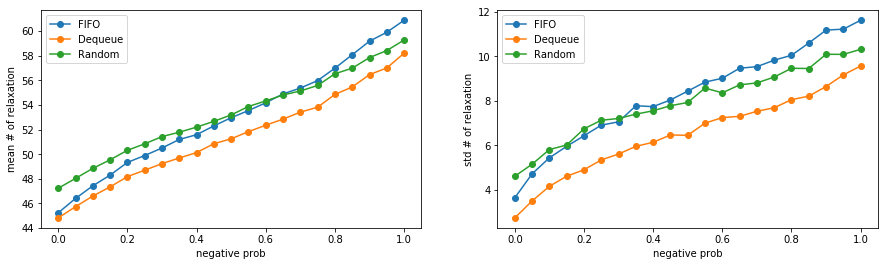

In [23]:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

x = np.arange(0, 1.01, 0.05)

ax1.plot(x, results_fifo[:, 0], marker="o",label="FIFO")
ax1.plot(x, results_dequeue[:, 0], marker="o",label="Dequeue")
ax1.plot(x, results_random[:, 0], marker="o",label="Random")

ax1.set_xlabel("negative prob")
ax1.set_ylabel("mean # of relaxation")
ax1.legend()

ax2.plot(x, results_fifo[:, 1], marker="o",label="FIFO")
ax2.plot(x, results_dequeue[:, 1], marker="o",label="Dequeue")
ax2.plot(x, results_random[:, 1], marker="o",label="Random")

ax2.set_xlabel("negative prob")
ax2.set_ylabel("std # of relaxation")
ax2.legend()

plt.show()